# Part6. <가격 모델링>

# Import

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from optuna import Trial
from optuna.samplers import TPESampler
import optuna
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold

In [151]:
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_palette('hls', n_colors=10)

%matplotlib inline
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

In [152]:
concert = pd.read_csv('data/target_generated_code5.csv')

C:\Users\milks\AppData\Local\Temp\ipykernel_23256\3733128326.py:1: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  concert = pd.read_csv('data/target_generated_code5.csv')


In [153]:
df = concert.copy()

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789486 entries, 0 to 789485
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tran_date         789486 non-null  object 
 1   tran_time         789486 non-null  int64  
 2   play_date         789486 non-null  int64  
 3   play_st_time      789486 non-null  int64  
 4   price             789486 non-null  int64  
 5   ticket_cancel     789486 non-null  int64  
 6   discount_type     789486 non-null  object 
 7   performance_code  789486 non-null  int64  
 8   pre_open_date     789486 non-null  float64
 9   open_date         789486 non-null  object 
 10  genre             789486 non-null  object 
 11  running_time      789486 non-null  int64  
 12  intermission      789486 non-null  int64  
 13  member_yn         789486 non-null  object 
 14  층                 789486 non-null  int64  
 15  자리번호              789486 non-null  int64  
 16  블록(박스)            78

# Feature Generation

### 공공성 측면

In [120]:
#노인, 학생, 어린이, 장애인 등은 티켓 가격이 일반 관람객보다 저렴할 것임

a = df[df.discount_type.str.contains('65세|실버|유족|학생|경로|장애|노블|의사상|임산|청소년|청년|유공|어린이|의상')]

small_dict = a.groupby('performance_code')['price'].count() / df.groupby('performance_code')['price'].count()

small_dict.fillna(0,inplace=True)

df['공연_취약계층비율'] = df['performance_code'].map(small_dict)

### 수익성 측면

In [121]:
#장르별 평균가
df['장르별 평균가'] = df.groupby('genre')['price'].transform('mean')

In [122]:
#장르별 공연 비율
a = df.groupby('genre')['performance_code'].count()/ df.shape[0]
df['장르별_공연비율'] = df['genre'].map(a)

In [123]:
#공연 상반기 하반기 분류
df['play_date'] = df['play_date'].astype('str')
df['play_date_year'] = df['play_date'].map(lambda x:x[:4])
df['play_date_month'] = df['play_date'].map(lambda x:x[4:6])

def categorize_month(month):
    if '01' <= month <= '06':
        return '0'
    elif '07' <= month <= '12':
        return '1'

# apply 함수를 사용하여 'play_date_month' 열을 변경
df['sang_han'] = df['play_date_month'].apply(categorize_month)

In [124]:
#month가 11월인지 아닌지 여부
df['play_date_month_11'] = (df['play_date_month'] == '11').astype(int)

### 만족도 측면

In [125]:
#재관람 여부 -> 공연에 대한 만족도 측면
df['is_rewatch']=df['discount_type'].str.contains('재관람').astype('int')

In [126]:
#멤버쉽 타입 피처 활용 +  discount_type -> 시스템에 대한 만족도 측면

#구매 당시 유료회원인 경우
df['now_yuro'] =df['discount_type'].str.contains('골드|그린|블루|법인').astype('int')

In [127]:
#주말 여부
df['play_date'] = df['play_date'].astype('str')
df['play_date'] = pd.to_datetime(df['play_date'], format='%Y%m%d')
df['play_day'] = df['play_date'].dt.day_name()

df.loc[df['play_day'].isin(['Friday', 'Saturday', 'Sunday']), 'weekend'] = 1
df.loc[~df['play_day'].isin(['Friday', 'Saturday', 'Sunday']), 'weekend'] = 0

In [128]:
#자리번호의 범주화
def categorize_seat_number(seat_number):
    if 1 <= seat_number <= 5:
        return 1
    elif 6 <= seat_number <= 10:
        return 2
    elif 11 <= seat_number <= 16:
        return 3
    else:
        return 4
    
df['자리번호_range'] = df['자리번호'].apply(categorize_seat_number)


---

# Encoding / Scaler

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789486 entries, 0 to 789485
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   tran_date           789486 non-null  object        
 1   tran_time           789486 non-null  int64         
 2   play_date           789486 non-null  datetime64[ns]
 3   play_st_time        789486 non-null  int64         
 4   price               789486 non-null  int64         
 5   ticket_cancel       789486 non-null  int64         
 6   discount_type       789486 non-null  object        
 7   performance_code    789486 non-null  int64         
 8   pre_open_date       789486 non-null  float64       
 9   open_date           789486 non-null  object        
 10  genre               789486 non-null  object        
 11  running_time        789486 non-null  int64         
 12  intermission        789486 non-null  int64         
 13  member_yn           789486 no

In [130]:
df = df[['performance_code','ticket_cancel','running_time','genre','member_yn','층','블록(박스)','자리번호','ori_price_mean',
         'now_yuro','공연_취약계층비율','장르별 평균가','weekend','장르별_공연비율',
        'sang_han','play_date_month_11','자리번호_range']]

In [131]:
numerical_feats = df.dtypes[df.dtypes != "object"].index.tolist()

numerical_feats.remove('ori_price_mean')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  12
Number of Categorical features:  4


In [132]:
for ord in categorical_feats:
    le = LabelEncoder()
    le.fit(df[ord].astype(str))
    df[ord] = le.transform(df[ord].astype(str))

In [133]:
scaler = StandardScaler()
df[numerical_feats] = scaler.fit_transform(df[numerical_feats])

# 상관관계

<Axes: >

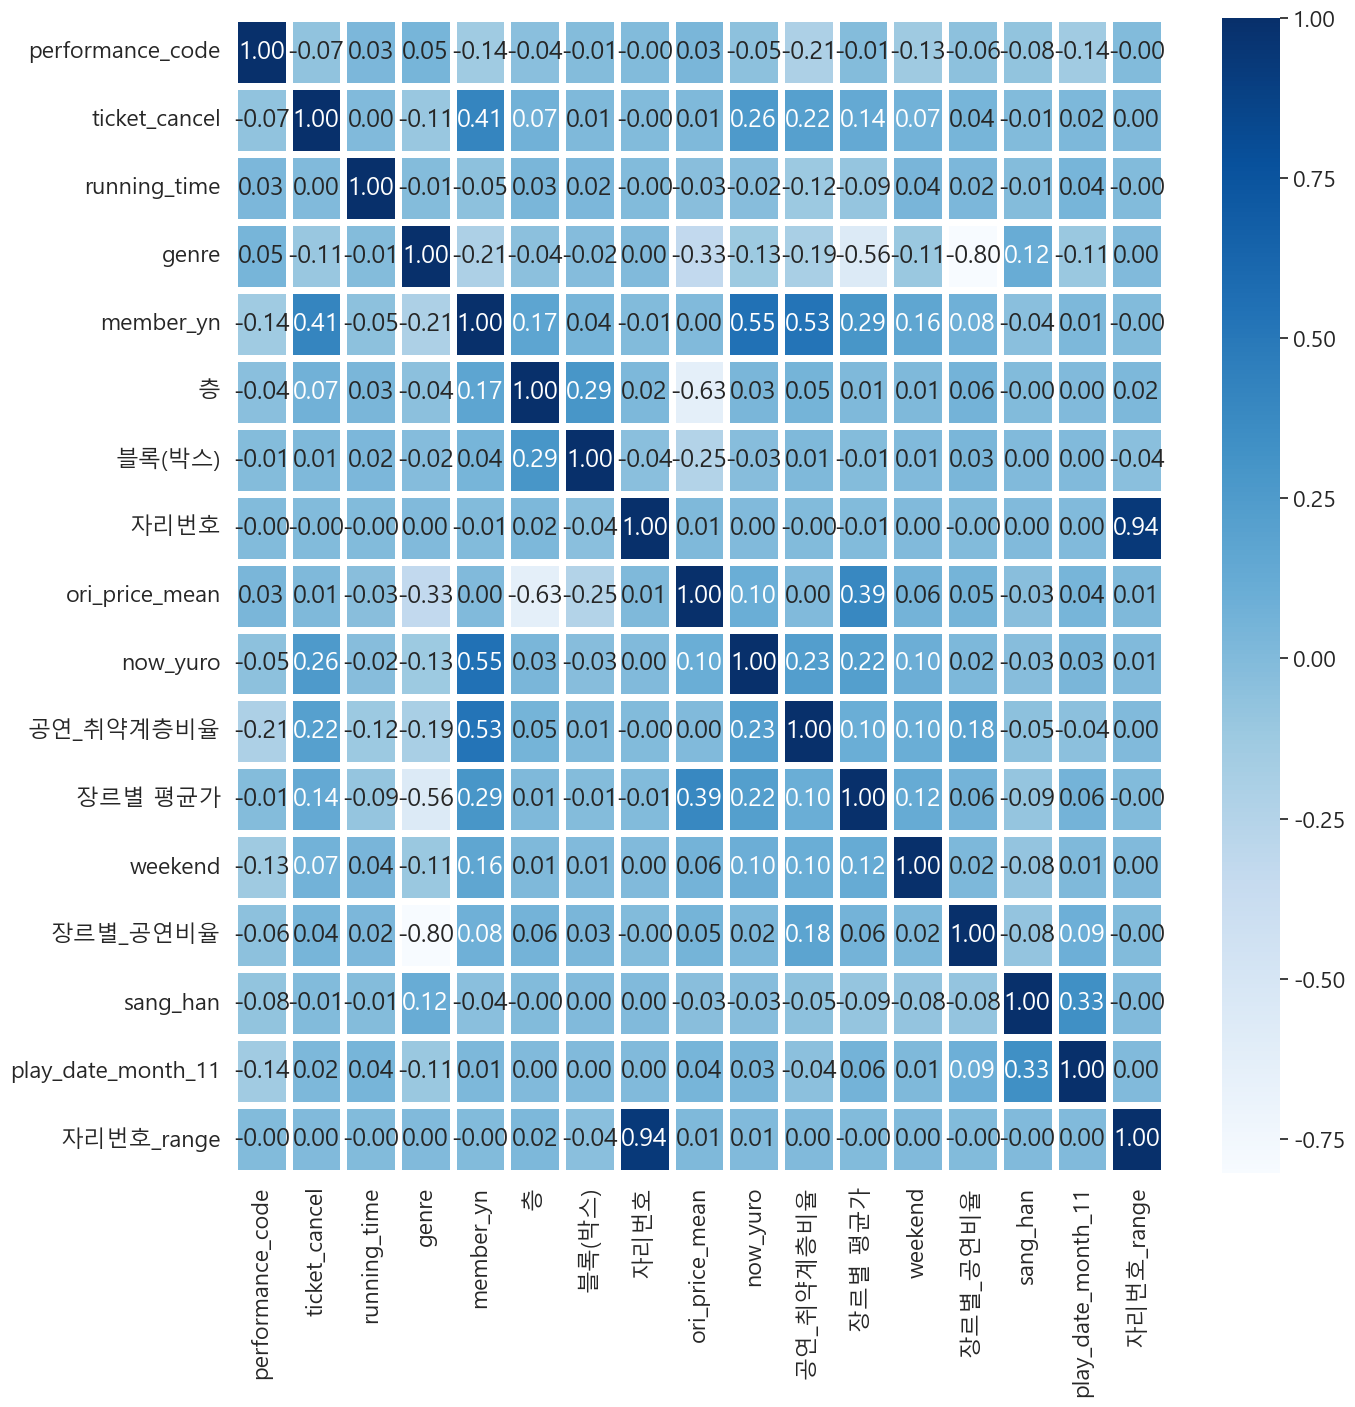

In [134]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', linewidths=5, cmap='Blues')

# Modeling

In [135]:
df2= df.copy()
df3= df.copy()

In [136]:
seed = 42

target = df2.ori_price_mean
train = df2.drop('ori_price_mean',axis = 1)

train, test, y_train, y_test = train_test_split(train,target,test_size=0.3, random_state=seed)

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

X_train, X_valid, y_train, y_valid = train_test_split(train,y_train,test_size=0.3, random_state=seed)

# 1. Tree model

## 1-1) DecisionTreeRegressor

In [137]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree 모델을 초기화하고 학습합니다.
dt_model = DecisionTreeRegressor(random_state=seed)
dt_model.fit(X_train, y_train)

val_pred = dt_model.predict(X_valid)
print('rmse_score:', mean_squared_error(y_valid, val_pred, squared=False))
print('mape_loss:', mean_absolute_percentage_error(y_valid, val_pred))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(y_valid, val_pred))

rmse_score: 9949.081695695531
mape_loss: 0.08747473954712454
MAE Score: 5821.775044023913
R2 Score: 0.8537230742163511


In [138]:
pred = dt_model.predict(test)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  9982.71512752902
mape_loss :  0.08481721950399064
MAE Score: 5821.775044023913
R2 Score: 0.8443574166504303


## 1-2) ExtraTreeRegressor

In [139]:
et_model = ExtraTreeRegressor(random_state=seed)
et_model.fit(X_train,y_train) 

val_pred = et_model.predict(X_valid)
print('rmse_score:', mean_squared_error(y_valid, val_pred, squared=False))
print('mape_loss:', mean_absolute_percentage_error(y_valid, val_pred))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(y_valid, val_pred))

rmse_score: 10005.90264823887
mape_loss: 0.08818348395098465
MAE Score: 5866.460636161243
R2 Score: 0.8520474766084084


In [140]:
pred = et_model.predict(test)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  10015.675177043733
mape_loss :  0.0854458410558029
MAE Score: 5866.460636161243
R2 Score: 0.843465285616115


## 1-3) RandomForest

In [141]:
rf_model = RandomForestRegressor(random_state=seed)
rf_model.fit(X_train, y_train)

val_pred = rf_model.predict(X_valid)
print('rmse_score:', mean_squared_error(y_valid, val_pred, squared=False))
print('mape_loss:', mean_absolute_percentage_error(y_valid, val_pred))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(y_valid, val_pred))

rmse_score: 9116.44215675319
mape_loss: 0.08631118173683004
MAE Score: 5720.507784821421
R2 Score: 0.8771824041404022


In [142]:
pred = rf_model.predict(test)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  9131.212630643253
mape_loss :  0.08282827240391658
MAE Score: 5720.507784821421
R2 Score: 0.8660677497057074


# 2. Boosting model

## 2-1) LGBMRegressor

In [143]:
lgbm_model = LGBMRegressor(random_state=seed)
lgbm_model.fit(X_train, y_train)

val_pred = lgbm_model.predict(X_valid)
print('rmse_score:', mean_squared_error(y_valid, val_pred, squared=False))
print('mape_loss:', mean_absolute_percentage_error(y_valid, val_pred))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(y_valid, val_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 386848, number of used features: 16
[LightGBM] [Info] Start training from score 71928.952092
rmse_score: 8608.229747468811
mape_loss: 0.09535587356930937
MAE Score: 6193.455378134949
R2 Score: 0.8904940973634543


In [144]:
pred = lgbm_model.predict(test)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  8629.138110698916
mape_loss :  0.09149864785964408
MAE Score: 6193.455378134949
R2 Score: 0.8748460873116153


## 2-2) GradientBoostingRegressor

In [145]:
gbm_model = GradientBoostingRegressor(random_state=seed)
gbm_model.fit(X_train,y_train)

val_pred = gbm_model.predict(X_valid)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  8629.138110698916
mape_loss :  0.09149864785964408
MAE Score: 7672.446834367995
R2 Score: 0.8748460873116153


In [146]:
pred = gbm_model.predict(test)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  9803.890000386706
mape_loss :  0.11488109213564379
MAE Score: 7672.446834367995
R2 Score: 0.8286427971462678


## 2-3) AdaBoostRegressor

In [147]:
abm_model = AdaBoostRegressor(random_state=seed)
abm_model.fit(X_train,y_train)

val_pred = abm_model.predict(X_valid)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  9803.890000386706
mape_loss :  0.11488109213564379
MAE Score: 12154.028402863716
R2 Score: 0.8286427971462678


In [148]:
pred = abm_model.predict(test)
print('rmse_score : ' ,mean_squared_error(pred, y_test, squared=False))
print('mape_loss : ' ,mean_absolute_percentage_error(pred, y_test))
print("MAE Score:", mean_absolute_error(y_valid, val_pred))
print("R2 Score:", r2_score(pred, y_test))

rmse_score :  13731.656210187199
mape_loss :  0.18135165695450886
MAE Score: 12154.028402863716
R2 Score: 0.45164935819783614


----

# Feature_importance

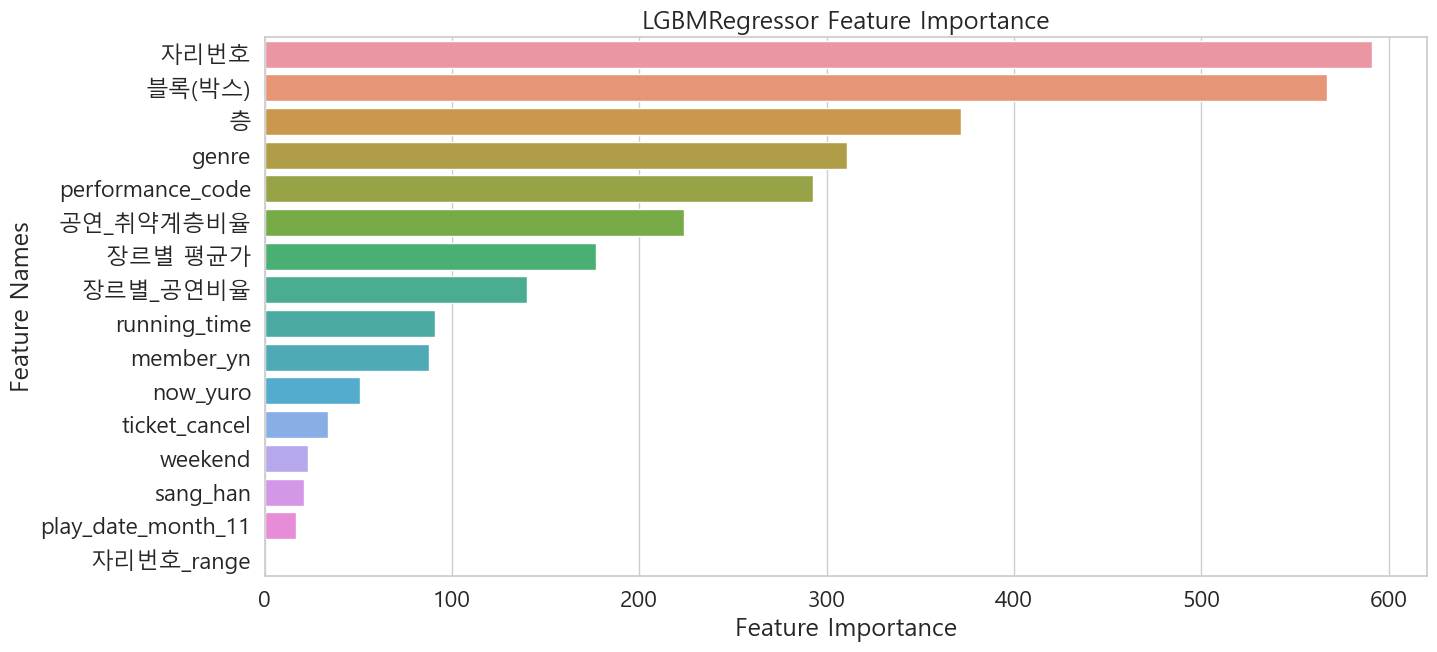

In [149]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(15, 7))  
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
plot_feature_importance(lgbm_model.feature_importances_, test.columns, 'LGBMRegressor')